# Import Data


In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import shap
import itertools
from itertools import product
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, cross_val_predict


In [97]:
def style_table(df, header_color='brown', font_size='10px', width='98%', show_head=10):
    """
    Уніфікована стилізація таблиці для pandas DataFrame.
    
    Parameters:
    - df: DataFrame для стилізації
    - header_color: Колір фону заголовка (default: 'brown')
    - font_size: Розмір шрифту (default: '10px')
    - width: Ширина таблиці (default: '98%')
    - show_head: Кількість рядків для показу (default: 10)
    
    Returns:
    - styled_df: Стилізований DataFrame
    """
    # Базові атрибути таблиці
    table_attrs = f'style="width: {width}; font-size: {font_size}; border-collapse: collapse;"'
    
    # Властивості для всіх комірок
    cell_props = {
        'background-color': 'white',
        'color': 'black',
        'border': '1px solid black',
        'text-align': 'center'
    }
    
    # Стилі для таблиці
    table_styles = [
        {
            'selector': 'th', 
            'props': [
                ('background-color', header_color), 
                ('color', 'white'), 
                ('font-weight', 'bold'), 
                ('text-align', 'center')
            ]
        },
        {
            'selector': 'td', 
            'props': [('text-align', 'center')]
        }
    ]
    
    # Застосування стилів
    styled_df = df.head(show_head).style \
        .set_table_attributes(table_attrs) \
        .set_properties(**cell_props) \
        .set_table_styles(table_styles)
    
    return styled_df

In [98]:
file_path = 'students_adaptability_level_online_education.csv'
try:  
    df = pd.read_csv(file_path)
    print("Дані успішно завантажені!")

    styled_df = style_table(df)

    display(styled_df)

except Exception as e:
    print("Помилка під час завантаження файлу:", e)

Дані успішно завантажені!


,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,Boy,21-25,University,Non Government,No,Yes,Low,Mid,Wifi,4G,3-6,No,Tab,Moderate
1,Girl,21-25,University,Non Government,No,Yes,High,Mid,Mobile Data,4G,1-3,Yes,Mobile,Moderate
2,Girl,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
3,Girl,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,4G,1-3,No,Mobile,Moderate
4,Girl,16-20,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,0,No,Mobile,Low
5,Boy,11-15,School,Non Government,No,Yes,Low,Poor,Mobile Data,3G,1-3,No,Mobile,Low
6,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,0,No,Mobile,Low
7,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Moderate
8,Boy,16-20,College,Government,No,Yes,Low,Mid,Wifi,4G,1-3,No,Mobile,Low
9,Boy,11-15,School,Non Government,No,Yes,Low,Mid,Mobile Data,3G,1-3,No,Mobile,Moderate


In [99]:
feature_values = []
for col in df.columns:
    unique_vals = sorted(df[col].dropna().unique())
    feature_values.append({
        "Feature Name": col,
        "Possible Values": ', '.join(map(str, unique_vals))
    })

features_df = pd.DataFrame(feature_values)

styled_features_df = features_df.style.set_table_attributes('style="width: 80%; font-size: 15px; border-collapse: collapse;"') \
    .set_properties(**{
        'background-color': '#f5f5f5',
        'color': '#222',
        'border': '1px solid #bbb',
        'text-align': 'center'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#444'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center')
        ]}
    ])

display(styled_features_df)

,Feature Name,Possible Values
0,Gender,"Boy, Girl"
1,Age,"1-5, 11-15, 16-20, 21-25, 26-30, 6-10"
2,Education Level,"College, School, University"
3,Institution Type,"Government, Non Government"
4,IT Student,"No, Yes"
5,Location,"No, Yes"
6,Load-shedding,"High, Low"
7,Financial Condition,"Mid, Poor, Rich"
8,Internet Type,"Mobile Data, Wifi"
9,Network Type,"2G, 3G, 4G"


# Data processing

In [100]:
missing_values = df.isnull().sum()

missing_table = missing_values.to_frame(name='Missing Values')
missing_table['Column Names'] = missing_table.index

missing_table = missing_table[['Column Names', 'Missing Values']]

styled_table = missing_table.style \
    .set_table_attributes('style="width: 60%; font-size: 15px; border-collapse: collapse;"') \
    .set_properties(**{
        'background-color': '#f5f5f5',
        'color': '#222',
        'border': '1px solid #bbb',
        'text-align': 'center'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#444'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center')
        ]}
    ]) \
    .hide(axis='index')

styled_table

Column Names,Missing Values
Gender,0
Age,0
Education Level,0
Institution Type,0
IT Student,0
Location,0
Load-shedding,0
Financial Condition,0
Internet Type,0
Network Type,0


In [101]:
df['Gender'] = df['Gender'].map({'Boy': 0, 'Girl': 1})
df['Age'] = df['Age'].map({'1-5': 0, '6-10': 1, '11-15': 2, '16-20': 3, '21-25': 4, '26-30': 5})
df['Education Level'] = df['Education Level'].map({'School': 0, 'College': 1, 'University': 2})
df['Institution Type'] = df['Institution Type'].map({'Government': 0, 'Non Government': 1})
df['IT Student'] = df['IT Student'].map({'No': 0, 'Yes': 1})
df['Location'] = df['Location'].map({'No': 0, 'Yes': 1})
df['Load-shedding'] = df['Load-shedding'].map({'Low': 0, 'High': 1})
df['Financial Condition'] = df['Financial Condition'].map({'Poor': 0, 'Mid': 1, 'Rich': 2})
df['Internet Type'] = df['Internet Type'].map({'Mobile Data': 0, 'Wifi': 1})
df['Network Type'] = df['Network Type'].map({'2G': 0, '3G': 1, '4G': 2})
df['Class Duration'] = df['Class Duration'].map({'0': 0, '1-3': 1, '3-6': 2})
df['Self Lms'] = df['Self Lms'].map({'No': 0, 'Yes': 1})
df['Device'] = df['Device'].map({'Mobile': 0, 'Tab': 1, 'Computer': 2})
df['Adaptivity Level'] = df['Adaptivity Level'].map({'Low': 0, 'Moderate': 1, 'High': 2})

print("Categorization completed!")

styled_df = df.head(10).style.set_table_attributes('style="width: 80%; font-size: 15px; border-collapse: collapse;"') \
    .set_properties(**{
        'background-color': '#f5f5f5',
        'color': '#222',
        'border': '1px solid #bbb',
        'text-align': 'center'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#444'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center')
        ]},
        {'selector': 'td', 'props': [
            ('text-align', 'center')
        ]}
    ])

display(styled_df)

Categorization completed!


,Gender,Age,Education Level,Institution Type,IT Student,Location,Load-shedding,Financial Condition,Internet Type,Network Type,Class Duration,Self Lms,Device,Adaptivity Level
0,0,4,2,1,0,1,0,1,1,2,2,0,1,1
1,1,4,2,1,0,1,1,1,0,2,1,1,0,1
2,1,3,1,0,0,1,0,1,1,2,1,0,0,1
3,1,2,0,1,0,1,0,1,0,2,1,0,0,1
4,1,3,0,1,0,1,0,0,0,1,0,0,0,0
5,0,2,0,1,0,1,0,0,0,1,1,0,0,0
6,0,2,0,1,0,1,0,1,1,2,0,0,0,0
7,0,2,0,1,0,1,0,1,1,2,1,0,0,1
8,0,3,1,0,0,1,0,1,1,2,1,0,0,0
9,0,2,0,1,0,1,0,1,0,1,1,0,0,1


# Preliminary analysis

In [102]:
X = df.drop('Adaptivity Level', axis=1)
y = df['Adaptivity Level']

results_list = []
for feature in X.columns:
    X_feature = X[[feature]]
    model = LinearRegression()
    model.fit(X_feature, y)
    y_pred = model.predict(X_feature)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    results_list.append({
        'Feature': feature,
        'R^2': r2,
        'Mean Squared Error (MSE)': mse
    })

results_df = pd.DataFrame(results_list)

styled_table = results_df.style \
    .format({'R^2': "{:.4f}", 'Mean Squared Error (MSE)': "{:.4f}"}) \
    .set_table_attributes('style="width: 80%; font-size: 15px; border-collapse: collapse; margin: auto;"') \
    .set_properties(**{
        'background-color': '#f5f5f5',
        'color': '#222',
        'border': '1px solid #bbb',
        'text-align': 'center',
        'padding': '8px'
    }) \
    .set_table_styles([
        {'selector': 'th', 'props': [
            ('background-color', '#444'),
            ('color', 'white'),
            ('font-weight', 'bold'),
            ('text-align', 'center'),
            ('border', '1px solid #bbb')
        ]},
        {'selector': 'caption', 'props': [
            ('caption-side', 'top'),
            ('font-size', '1.2em'),
            ('font-weight', 'bold'),
            ('margin-bottom', '10px')
        ]}
    ]) \
    .hide(axis='index')

styled_table

Feature,R^2,Mean Squared Error (MSE)
Gender,0.0090,0.3785
Age,0.0030,0.3807
Education Level,0.0006,0.3817
Institution Type,0.0729,0.3541
IT Student,0.0152,0.3761
Location,0.0629,0.3579
Load-shedding,0.0072,0.3791
Financial Condition,0.0568,0.3602
Internet Type,0.0080,0.3788
Network Type,0.0201,0.3742


In [103]:
X = df.drop('Adaptivity Level', axis=1)
y = df['Adaptivity Level']

rf_model = RandomForestClassifier(
    max_depth=20,
    n_estimators=100,
    random_state=42
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_val_score(rf_model, X, y, cv=skf, scoring='accuracy')

print("10-fold Stratified Cross-Validation Results:\n")
print(f"Accuracy for each of the 10 folds: \n{np.round(scores, 4)}")
print(f"\nMean Accuracy: {scores.mean():.4f}")
print(f"Standard Deviation: {scores.std():.4f}\n")

rf_model.fit(X, y)
y_pred = cross_val_predict(rf_model, X, y, cv=skf)

print("\nDetailed Classification Report:")
print(classification_report(y, y_pred))

10-fold Stratified Cross-Validation Results:

Accuracy for each of the 10 folds: 
[0.9339 0.9091 0.9587 0.9091 0.9421 0.95   0.9    0.875  0.925  0.9   ]

Mean Accuracy: 0.9203
Standard Deviation: 0.0248


Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.93      0.93       480
           1       0.92      0.93      0.93       625
           2       0.88      0.80      0.84       100

    accuracy                           0.92      1205
   macro avg       0.91      0.89      0.90      1205
weighted avg       0.92      0.92      0.92      1205



# Objective enumeration function

,Feature,SHAP Weight (class 1)
0,Gender,0.043260
1,Age,0.046524
2,Education Level,0.038731
3,Institution Type,0.056130
4,IT Student,0.032008
5,Location,0.041893
6,Load-shedding,0.019087
7,Financial Condition,0.063012
8,Internet Type,0.036471
9,Network Type,0.037861


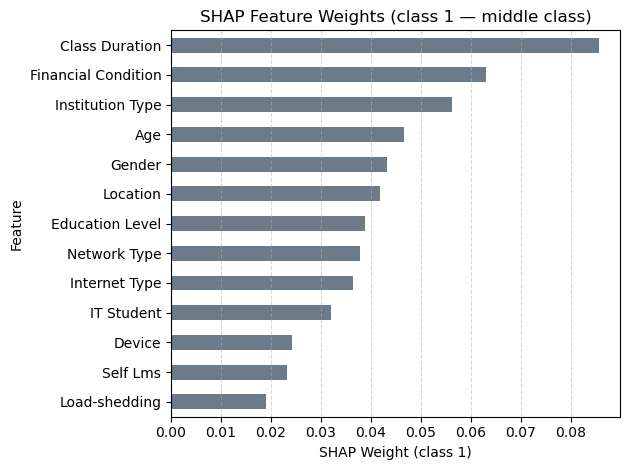

,Feature,Scaled SHAP Weight (class 1)
0,Gender,0.505538
1,Age,0.543683
2,Education Level,0.452615
3,Institution Type,0.655942
4,IT Student,0.374053
5,Location,0.489568
6,Load-shedding,0.223049
7,Financial Condition,0.736372
8,Internet Type,0.426208
9,Network Type,0.442446


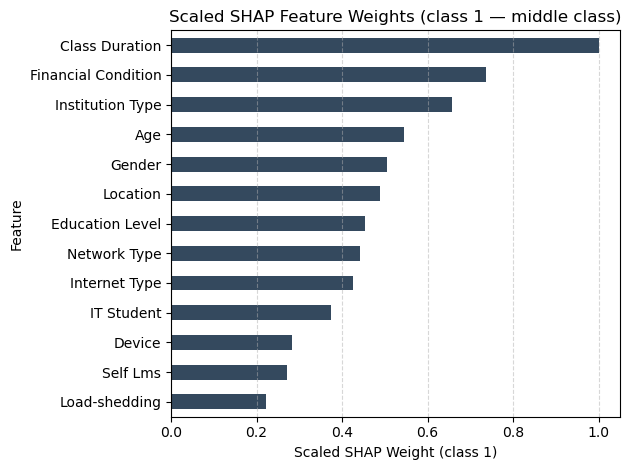

In [104]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X)
class_value = 1
class_index = list(rf_model.classes_).index(class_value)

if len(shap_values.values.shape) == 3:
    class_shap_values = shap_values.values[:, :, class_index]
    mean_abs_shap = np.abs(class_shap_values).mean(axis=0)
else:
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)

shap_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Weight (class 1)': mean_abs_shap
})

styled_shap = shap_df.style.set_table_attributes(
    'style="width: 80%; font-size: 15px; border-collapse: collapse;"'
).set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#222',
    'border': '1px solid #bbb',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#444'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('border', '1px solid #bbb')
    ]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_shap)

shap_df_sorted = shap_df.sort_values(by='SHAP Weight (class 1)', ascending=True)
shap_df_sorted.plot(kind='barh', x='Feature', y='SHAP Weight (class 1)', color='#6c7a89', legend=False)
plt.xlabel("SHAP Weight (class 1)")
plt.title("SHAP Feature Weights (class 1 — middle class)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

shap_df['Scaled SHAP Weight (class 1)'] = shap_df['SHAP Weight (class 1)'] / shap_df['SHAP Weight (class 1)'].max()

styled_scaled_shap = shap_df[['Feature', 'Scaled SHAP Weight (class 1)']].style.set_table_attributes(
    'style="width: 80%; font-size: 15px; border-collapse: collapse;"'
).set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#222',
    'border': '1px solid #bbb',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#444'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('border', '1px solid #bbb')
    ]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_scaled_shap)

shap_df_sorted_scaled = shap_df.sort_values(by='Scaled SHAP Weight (class 1)', ascending=True)
shap_df_sorted_scaled.plot(kind='barh', x='Feature', y='Scaled SHAP Weight (class 1)', color='#34495e', legend=False)
plt.xlabel("Scaled SHAP Weight (class 1)")
plt.title("Scaled SHAP Feature Weights (class 1 — middle class)")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [132]:
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer(X)
class_value = 1
class_index = list(rf_model.classes_).index(class_value)

if len(shap_values.values.shape) == 3:
    class_shap_values = shap_values.values[:, :, class_index]
    mean_abs_shap = np.abs(class_shap_values).mean(axis=0)
    median_abs_shap = np.median(np.abs(class_shap_values), axis=0)  # Додано: медіана abs SHAP
else:
    mean_abs_shap = np.abs(shap_values.values).mean(axis=0)
    median_abs_shap = np.median(np.abs(shap_values.values), axis=0)  # Для 2D

shap_df = pd.DataFrame({
    'Feature': X.columns,
    'SHAP Weight': mean_abs_shap,
    'Median SHAP Weight': median_abs_shap  # Додано колонку
})

shap_df['Scaled SHAP Weight'] = shap_df['SHAP Weight'] / shap_df['SHAP Weight'].max()
shap_df['Scaled Median SHAP Weight'] = shap_df['Median SHAP Weight'] / shap_df['Median SHAP Weight'].max()  # Масштабована медіана

# Фокус на останніх 5 (modifiable_features)
shap_df_last5 = shap_df.tail(5).copy().reset_index(drop=True)
shap_df_last5_sorted = shap_df_last5.sort_values(by='SHAP Weight', ascending=False).reset_index(drop=True)
shap_df_last5_sorted.index = np.arange(1, 6)

# Print медіани для фіч
print("Median SHAP for modifiable features:")
print(shap_df_last5_sorted[['Feature', 'Median SHAP Weight', 'Scaled Median SHAP Weight']])

styled_shap_last5 = shap_df_last5_sorted.style.set_table_attributes(
    'style="width: 80%; font-size: 15px; border-collapse: collapse;"'
).set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#222',
    'border': '1px solid #bbb',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#444'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('border', '1px solid #bbb')
    ]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_shap_last5)

Median SHAP for modifiable features:
          Feature  Median SHAP Weight  Scaled Median SHAP Weight
1  Class Duration            0.049124                   1.000000
2    Network Type            0.026566                   0.540798
3   Internet Type            0.031027                   0.631604
4          Device            0.013192                   0.268538
5        Self Lms            0.009130                   0.185848


,Feature,SHAP Weight,Median SHAP Weight,Scaled SHAP Weight,Scaled Median SHAP Weight
1,Class Duration,0.085572,0.049124,1.000000,1.000000
2,Network Type,0.037861,0.026566,0.442446,0.540798
3,Internet Type,0.036471,0.031027,0.426208,0.631604
4,Device,0.024181,0.013192,0.282581,0.268538
5,Self Lms,0.023135,0.009130,0.270357,0.185848


In [106]:
df_penalty = df.copy()

rules = [
    ("Mobile Data ∧ Network=2G ∧ ClassDuration=3-6",
     (df_penalty['Internet Type'] == 0) & (df_penalty['Network Type'] == 0) & (df_penalty['Class Duration'] == 2)),
    ("ClassDuration=3-6 ∧ Device=Mobile",
     (df_penalty['Class Duration'] == 2) & (df_penalty['Device'] == 0)),
    ("ClassDuration=0 ∧ Self LMS=Yes",
     (df_penalty['Class Duration'] == 0) & (df_penalty['Self Lms'] == 1)),
    ("ClassDuration=0 ∧ Device=Computer",
     (df_penalty['Class Duration'] == 0) & (df_penalty['Device'] == 2)),
    ("Device=Computer ∧ Mobile Data ∧ Network=2G",
     (df_penalty['Device'] == 2) & (df_penalty['Internet Type'] == 0) & (df_penalty['Network Type'] == 0)),
    ("Device=Tab ∧ Mobile Data ∧ Network=2G",
     (df_penalty['Device'] == 1) & (df_penalty['Internet Type'] == 0) & (df_penalty['Network Type'] == 0)),
    ("Financial=Poor ∧ Device=Computer",
     (df_penalty['Financial Condition'] == 0) & (df_penalty['Device'] == 2)),
    ("Load-shedding=High ∧ ClassDuration=3-6",
     (df_penalty['Load-shedding'] == 1) & (df_penalty['Class Duration'] == 2)),
    ("Device=Computer ∧ Load-shedding=High",
     (df_penalty['Device'] == 2) & (df_penalty['Load-shedding'] == 1)),
    ("IT Student=Yes ∧ Self LMS=No ∧ Class Duration=0",
     (df_penalty['IT Student'] == 1) & (df_penalty['Self Lms'] == 0) & (df_penalty['Class Duration'] == 0))
]

penalties = []
for desc, mask in rules:
    freq = mask.mean()
    if freq == 0:
        penalty = float('inf')
    else:
        penalty = 1 - freq
    penalties.append((desc, freq * 100, penalty))

result_df = pd.DataFrame(penalties, columns=["Rule", "Frequency (%)", "Penalty"])
result_df.index = np.arange(1, len(result_df) + 1)

def format_freq(x):
    return f"{x:.4f}" if not np.isinf(x) else x

def format_penalty(x):
    return f"{x:.6f}" if not np.isinf(x) else x

styled_result_df = result_df.style.format({
    "Frequency (%)": format_freq,
    "Penalty": format_penalty
}).set_table_attributes(
    'style="width: 80%; font-size: 15px; border-collapse: collapse;"'
).set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#222',
    'border': '1px solid #bbb',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#444'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('border', '1px solid #bbb')
    ]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_result_df)

saved_penalties = dict(zip(result_df["Rule"], result_df["Penalty"]))

,Rule,Frequency (%),Penalty
1,Mobile Data ∧ Network=2G ∧ ClassDuration=3-6,0.0000,inf
2,ClassDuration=3-6 ∧ Device=Mobile,9.5436,0.904564
3,ClassDuration=0 ∧ Self LMS=Yes,0.1660,0.998340
4,ClassDuration=0 ∧ Device=Computer,0.4979,0.995021
5,Device=Computer ∧ Mobile Data ∧ Network=2G,0.0000,inf
6,Device=Tab ∧ Mobile Data ∧ Network=2G,0.0000,inf
7,Financial=Poor ∧ Device=Computer,1.4108,0.985892
8,Load-shedding=High ∧ ClassDuration=3-6,5.4772,0.945228
9,Device=Computer ∧ Load-shedding=High,2.7386,0.972614
10,IT Student=Yes ∧ Self LMS=No ∧ Class Duration=0,1.3278,0.986722


# Results (exhaustive algorithm for 1 example)

In [107]:
scaled_df = df.copy()
scaled_df['Adaptivity'] = scaled_df['Adaptivity Level']

weights = shap_df.set_index('Feature')['Scaled SHAP Weight'].to_dict()
features_of_interest = ["Internet Type", "Network Type", "Class Duration", "Self Lms", "Device"]

low_candidates = scaled_df[scaled_df['Adaptivity'] == 0]
low_student = low_candidates.iloc[22] if not low_candidates.empty and len(low_candidates) > 22 else scaled_df.iloc[0]

current_student = low_student[features_of_interest].to_dict()
base_full_state = low_student[X.columns].to_dict()

readable_map = {
    "Internet Type": {0: "Mobile Data", 1: "WiFi"},
    "Network Type": {0: "2G", 1: "3G", 2: "4G"},
    "Class Duration": {0: "0", 1: "1-2", 2: "3-6"},
    "Self Lms": {0: "No", 1: "Yes"},
    "Device": {0: "Mobile", 1: "Tab", 2: "Computer"},
    "Financial Condition": {0: "Poor", 1: "Good"},
    "Load-shedding": {0: "Low", 1: "High"},
    "IT Student": {0: "No", 1: "Yes"},
    "Adaptivity": {0: "Low", 1: "Moderate", 2: "High"}
}

current_student_readable = {f: readable_map.get(f, {}).get(v, v) for f, v in current_student.items()}
low_student_readable = {f: readable_map.get(f, {}).get(v, v) for f, v in low_student.items()}

possible_values = {
    "Internet Type": [0, 1],
    "Network Type": [0, 1, 2],
    "Class Duration": [0, 1, 2],
    "Self Lms": [0, 1],
    "Device": [0, 1, 2]
}

df_penalty = df.copy()
rule_masks = {
    "rule1": (df_penalty['Internet Type']==0) & (df_penalty['Network Type']==0) & (df_penalty['Class Duration']==2),
    "rule2": (df_penalty['Class Duration']==2) & (df_penalty['Device']==0),
    "rule3": (df_penalty['Class Duration']==0) & (df_penalty['Self Lms']==1),
    "rule4": (df_penalty['Class Duration']==0) & (df_penalty['Device']==2),
    "rule5": (df_penalty['Device']==2) & (df_penalty['Internet Type']==0) & (df_penalty['Network Type']==0),
    "rule6": (df_penalty['Device']==1) & (df_penalty['Internet Type']==0) & (df_penalty['Network Type']==0),
    "rule7": (df_penalty['Financial Condition']==0) & (df_penalty['Device']==2),
    "rule8": (df_penalty['Load-shedding']==1) & (df_penalty['Class Duration']==2),
    "rule9": (df_penalty['Device']==2) & (df_penalty['Load-shedding']==1),
    "rule10": (df_penalty['IT Student']==1) & (df_penalty['Self Lms']==0) & (df_penalty['Class Duration']==0)
}

rule_penalties = {r: 1-mask.mean() if mask.mean()>0 else float('inf') for r, mask in rule_masks.items()}

def L0(current, new):
    return sum(current[f] != new[f] for f in current.keys())

def compute_penalty_dynamic(scenario, student_base):
    penalty = 0.0
    if scenario["Internet Type"] == 0 and scenario["Network Type"] == 0 and scenario["Class Duration"] == 2:
        penalty += rule_penalties["rule1"]
    if scenario["Class Duration"] == 2 and scenario["Device"] == 0:
        penalty += rule_penalties["rule2"]
    if scenario["Class Duration"] == 0 and scenario["Self Lms"] == 1:
        penalty += rule_penalties["rule3"]
    if scenario["Class Duration"] == 0 and scenario["Device"] == 2:
        penalty += rule_penalties["rule4"]
    if scenario["Device"] == 2 and scenario["Internet Type"] == 0 and scenario["Network Type"] == 0:
        penalty += rule_penalties["rule5"]
    if scenario["Device"] == 1 and scenario["Internet Type"] == 0 and scenario["Network Type"] == 0:
        penalty += rule_penalties["rule6"]
    if student_base["Financial Condition"] == 0 and scenario["Device"] == 2:
        penalty += rule_penalties["rule7"]
    if student_base["Load-shedding"] == 1 and scenario["Class Duration"] == 2:
        penalty += rule_penalties["rule8"]
    if scenario["Device"] == 2 and student_base["Load-shedding"] == 1:
        penalty += rule_penalties["rule9"]
    if student_base["IT Student"] == 1 and scenario["Self Lms"] == 0 and scenario["Class Duration"] == 0:
        penalty += rule_penalties["rule10"]
    return penalty

def compute_cost(current, new, weights, alpha, student_base):
    l0 = L0(current, new)
    weighted_sum = sum(weights.get(f, 1.0) for f in current.keys() if current[f] != new[f])
    penalty = compute_penalty_dynamic(new, student_base)
    return alpha * l0 + weighted_sum + penalty

feature_combinations = list(itertools.product(
    possible_values["Internet Type"],
    possible_values["Network Type"],
    possible_values["Class Duration"],
    possible_values["Self Lms"],
    possible_values["Device"]
))

label_map = {0: "Low", 1: "Moderate", 2: "High"}

alphas = np.arange(0.01, 1.01, 0.01)
best_alpha = None
best_mean_cost = float("inf")
best_scenario_costs = None

for alpha in alphas:
    scenario_costs = []
    for comb in feature_combinations:
        new_partial = dict(zip(features_of_interest, comb))
        new_full = base_full_state.copy()
        new_full.update(new_partial)
        new_row = pd.DataFrame([new_full], columns=X.columns)
        pred = rf_model.predict(new_row)[0]
        if pred == 1:
            penalty = compute_penalty_dynamic(new_partial, low_student)
            cost = compute_cost(current_student, new_partial, weights, alpha, low_student)
            scenario_costs.append({
                "Changed Features": {f: readable_map[f].get(v, v) for f, v in new_partial.items()},
                "Cost": round(cost, 6),
                "Number of Changed Features": L0(current_student, new_partial),
                "Penalty": "Yes" if penalty > 0 else "No",
                "New Level": label_map.get(pred, "NA")
            })

    top5 = sorted(scenario_costs, key=lambda x: x["Cost"])[:5]

    if top5:
        mean_cost = np.mean([s["Number of Changed Features"] for s in top5])
    else:
        mean_cost = float("inf")

    if mean_cost < best_mean_cost:
        best_mean_cost = mean_cost
        best_alpha = alpha
        best_scenario_costs = top5

reverse_map = {
    "Gender": {0: "Boy", 1: "Girl"},
    "Age": {0: "1-5", 1: "6-10", 2: "11-15", 3: "16-20", 4: "21-25", 5: "26-30"},
    "Education Level": {0: "School", 1: "College", 2: "University"},
    "Institution Type": {0: "Government", 1: "Non Government"},
    "IT Student": {0: "No", 1: "Yes"},
    "Location": {0: "No", 1: "Yes"},
    "Load-shedding": {0: "Low", 1: "High"},
    "Financial Condition": {0: "Poor", 1: "Mid", 2: "Rich"},
    "Internet Type": {0: "Mobile Data", 1: "WiFi"},
    "Network Type": {0: "2G", 1: "3G", 2: "4G"},
    "Class Duration": {0: "0", 1: "1-3", 2: "3-6"},
    "Self Lms": {0: "No", 1: "Yes"},
    "Device": {0: "Mobile", 1: "Tab", 2: "Computer"},
    "Adaptivity Level": {0: "Low", 1: "Moderate", 2: "High"},
    "Adaptivity": {0: "Low", 1: "Moderate", 2: "High"}
}

current_student_readable_full = {col: reverse_map.get(col, {}).get(val, val) for col, val in low_student.items()}

student_df = pd.DataFrame(list(current_student_readable_full.items()), columns=["Feature Name", "Feature Value"])
student_df = student_df.iloc[:-1, :]

styled_student_df = student_df.style.set_table_attributes(
    'style="width: 80%; font-size: 15px; border-collapse: collapse;"'
).set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#222',
    'border': '1px solid #bbb',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#444'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('border', '1px solid #bbb')
    ]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_student_df)

alpha_df = pd.DataFrame({
    "Parameter": ["Best alpha", "Mean number of changed features"],
    "Value": [f"{best_alpha:.2f}".rstrip('0').rstrip('.'), f"{best_mean_cost:.2f}".rstrip('0').rstrip('.')]
})

styled_alpha_df = alpha_df.style.set_table_attributes(
    'style="width: 60%; font-size: 15px; border-collapse: collapse;"'
).set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#222',
    'border': '1px solid #bbb',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#444'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('border', '1px solid #bbb')
    ]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_alpha_df)

top_df = pd.DataFrame(best_scenario_costs)
top_df.index = np.arange(1, len(top_df) + 1)

top_df["Cost"] = top_df["Cost"].apply(lambda x: f"{x:.6f}")

styled_top_df = top_df.style.set_table_attributes(
    'style="width: 90%; font-size: 15px; border-collapse: collapse;"'
).set_properties(**{
    'background-color': '#f5f5f5',
    'color': '#222',
    'border': '1px solid #bbb',
    'text-align': 'center'
}).set_table_styles([
    {'selector': 'th', 'props': [
        ('background-color', '#444'),
        ('color', 'white'),
        ('font-weight', 'bold'),
        ('text-align', 'center'),
        ('border', '1px solid #bbb')
    ]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

display(styled_top_df)

,Feature Name,Feature Value
0,Gender,Boy
1,Age,21-25
2,Education Level,University
3,Institution Type,Government
4,IT Student,No
5,Location,Yes
6,Load-shedding,Low
7,Financial Condition,Mid
8,Internet Type,Mobile Data
9,Network Type,4G


,Parameter,Value
0,Best alpha,0.78
1,Mean number of changed features,1.8


,Changed Features,Cost,Number of Changed Features,Penalty,New Level
1,"{'Internet Type': 'Mobile Data', 'Network Type': '4G', 'Class Duration': '3-6', 'Self Lms': 'No', 'Device': 'Mobile'}",2.684564,1,Yes,Moderate
2,"{'Internet Type': 'Mobile Data', 'Network Type': '4G', 'Class Duration': '3-6', 'Self Lms': 'No', 'Device': 'Tab'}",2.842581,2,No,Moderate
3,"{'Internet Type': 'Mobile Data', 'Network Type': '4G', 'Class Duration': '3-6', 'Self Lms': 'No', 'Device': 'Computer'}",2.842581,2,No,Moderate
4,"{'Internet Type': 'Mobile Data', 'Network Type': '4G', 'Class Duration': '3-6', 'Self Lms': 'Yes', 'Device': 'Mobile'}",3.734921,2,Yes,Moderate
5,"{'Internet Type': 'WiFi', 'Network Type': '4G', 'Class Duration': '3-6', 'Self Lms': 'No', 'Device': 'Mobile'}",3.890772,2,Yes,Moderate


# Objective brute-force algorithm (exhaustive method)

In [108]:
# 1. Підготовка ---
# --- Обчислюємо частоти для штрафів заздалегідь ---
rule_frequencies = {}
for desc, mask in rules:
    freq = mask.mean()
    rule_frequencies[desc] = freq if freq > 0 else 0  # Уникаємо inf для freq=0

# --- Функція для перевірки комбо в x_prime ---
def check_rule_violation(x_prime, base, rule_desc):
    # Явні перевірки для кожної rules
    if "Mobile Data ∧ Network=2G ∧ ClassDuration=3-6" in rule_desc:
        return (x_prime.get('Internet Type', base['Internet Type']) == 0 and 
                x_prime.get('Network Type', base['Network Type']) == 0 and 
                x_prime.get('Class Duration', base['Class Duration']) == 2)
    elif "ClassDuration=3-6 ∧ Device=Mobile" in rule_desc:
        return (x_prime.get('Class Duration', base['Class Duration']) == 2 and 
                x_prime.get('Device', base['Device']) == 0)
    elif "ClassDuration=0 ∧ Self LMS=Yes" in rule_desc:
        return (x_prime.get('Class Duration', base['Class Duration']) == 0 and 
                x_prime.get('Self Lms', base['Self Lms']) == 1)
    elif "ClassDuration=0 ∧ Device=Computer" in rule_desc:
        return (x_prime.get('Class Duration', base['Class Duration']) == 0 and 
                x_prime.get('Device', base['Device']) == 2)
    elif "Device=Computer ∧ Mobile Data ∧ Network=2G" in rule_desc:
        return (x_prime.get('Device', base['Device']) == 2 and 
                x_prime.get('Internet Type', base['Internet Type']) == 0 and 
                x_prime.get('Network Type', base['Network Type']) == 0)
    elif "Device=Tab ∧ Mobile Data ∧ Network=2G" in rule_desc:
        return (x_prime.get('Device', base['Device']) == 1 and 
                x_prime.get('Internet Type', base['Internet Type']) == 0 and 
                x_prime.get('Network Type', base['Network Type']) == 0)
    elif "Financial=Poor ∧ Device=Computer" in rule_desc:
        return (base['Financial Condition'] == 0 and  # Immutable, so base
                x_prime.get('Device', base['Device']) == 2)
    elif "Load-shedding=High ∧ ClassDuration=3-6" in rule_desc:
        return (base['Load-shedding'] == 1 and  # Immutable
                x_prime.get('Class Duration', base['Class Duration']) == 2)
    elif "Device=Computer ∧ Load-shedding=High" in rule_desc:
        return (x_prime.get('Device', base['Device']) == 2 and 
                base['Load-shedding'] == 1)  # Immutable
    elif "IT Student=Yes ∧ Self LMS=No ∧ Class Duration=0" in rule_desc:
        return (base['IT Student'] == 1 and  # Immutable
                x_prime.get('Self Lms', base['Self Lms']) == 0 and 
                x_prime.get('Class Duration', base['Class Duration']) == 0)
    return False

In [136]:
# 2. "Low"-рівень адаптивності ---
low_students = df[df['Adaptivity Level'] == 0].copy()

# --- 3. Задаємо модифіковані фічі ---
modifiable_features = ['Internet Type', 'Network Type', 'Class Duration', 'Self Lms', 'Device']

# --- 4. Можливі значення для кожної фічі ---
value_space = {
    'Internet Type': [0, 1],        # Mobile, WiFi
    'Network Type': [0, 1, 2],      # 2G, 3G, 4G
    'Class Duration': [0, 1, 2],    # 0, 1-3, 3-6
    'Self Lms': [0, 1],             # No, Yes
    'Device': [0, 1, 2]             # Mobile, Tab, Computer
}

# --- 5. Витягуємо SHAP-ваги ---
weights = dict(zip(shap_df['Feature'], shap_df['Scaled SHAP Weight']))

# --- 6. Параметри (alpha тюнінг)
alpha = 0.05  # Штраф за кількість змін

results = []

# --- 7. Основний цикл по кожному студенту ---
for idx, row in low_students.iterrows():
    base = row.to_dict()
    
    # Генеруємо всі можливі x' для modifiable_features
    possible_configs = list(product(
        value_space['Internet Type'],
        value_space['Network Type'],
        value_space['Class Duration'],
        value_space['Self Lms'],
        value_space['Device']
    ))
    
    best_cost = float('inf')
    best_x_prime = None
    best_changed = []
    
    for config in possible_configs:
        x_prime = dict(zip(modifiable_features, config))
        
        # Обчислюємо y (зміни)
        changed = [f for f, val in x_prime.items() if val != base[f]]
        num_changes = len(changed)
        
        if num_changes == 0:  # Пропустити без змін
            continue
        
        # Cost без Penalty
        base_cost = alpha * num_changes + sum(weights[f] for f in changed)
        
        # Додаємо Penalty
        penalty = 0
        for desc in [r[0] for r in rules]:  # Тільки desc для ітерації
            if check_rule_violation(x_prime, base, desc):
                freq = rule_frequencies[desc]
                penalty += float('inf') if freq == 0 else (1 - freq)

        total_cost = base_cost + penalty
        
        if total_cost >= best_cost:
            continue
        
        # Формуємо X для перевірки RF
        X_cols = [c for c in df.columns if c != 'Adaptivity Level']
        new_profile = base.copy()
        new_profile.update(x_prime)
        new_df = pd.DataFrame([{k: new_profile[k] for k in X_cols}])
        
        pred_new = rf_model.predict(new_df)[0]
        
        if pred_new > 0:  # Покращення (до Moderate/High)
            best_cost = total_cost
            best_x_prime = x_prime
            best_changed = changed
    
    # Зберігаємо найкращий (або None, якщо немає покращення)
    if best_x_prime:
        pred_old = 0  # Low
        base_df = pd.DataFrame([{k: base[k] for k in X_cols}])
        pred_new = rf_model.predict(base_df)[0]  # Підтверджуємо old (хоч і 0)
        results.append({
            'Student ID': idx,
            'Changed Features': ', '.join(best_changed) if best_changed else 'No Change',
            'x_prime': best_x_prime,  
            'Cost': round(best_cost, 3),
            'Old Class': pred_old,
            'New Class': pred_new,
            'Improved': 1
        })
    else:
        results.append({
            'Student ID': idx,
            'Changed Features': '-',
            'x_prime': {f: base[f] for f in modifiable_features}, 
            'Cost': 0,
            'Old Class': 0,
            'New Class': 0,
            'Improved': 0
        })

# --- 8. Формуємо таблицю ---
results_df = pd.DataFrame(results)
improved_df = results_df[results_df['Improved'] == 1]
print(f"✅ Optimization complete for {len(results_df)} students. Improved: {len(improved_df)} ({len(improved_df)/len(results_df)*100:.1f}%).")

# Показуємо покращених
if len(improved_df) > 0:
    display(improved_df.head(10).sort_values('Cost'))
else:
    print("❌ No improvements found — check RF sensitivity or value_space.")
    display(results_df.head(10))

✅ Optimization complete for 480 students. Improved: 459 (95.6%).


,Student ID,Changed Features,x_prime,Cost,Old Class,New Class,Improved
3,8,Self Lms,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.320,0,0,1
5,11,Self Lms,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.320,0,0,1
4,10,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,0,1
1,5,Internet Type,"{'Internet Type': 1, 'Network Type': 1, 'Class...",0.476,0,0,1
7,15,Internet Type,"{'Internet Type': 0, 'Network Type': 2, 'Class...",0.476,0,0,1
6,13,Network Type,"{'Internet Type': 1, 'Network Type': 0, 'Class...",0.492,0,0,1
9,17,"Internet Type, Self Lms","{'Internet Type': 0, 'Network Type': 2, 'Class...",0.797,0,0,1
2,6,Class Duration,"{'Internet Type': 1, 'Network Type': 2, 'Class...",1.050,0,0,1
0,4,"Class Duration, Self Lms","{'Internet Type': 0, 'Network Type': 1, 'Class...",1.370,0,0,1
8,16,"Class Duration, Device","{'Internet Type': 0, 'Network Type': 2, 'Class...",1.383,0,0,1


In [115]:
results_df[(results_df['New Class'] != 0)]

,Student ID,Changed Features,x_prime,Cost,Old Class,New Class,Improved
4,10,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
5,11,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
10,18,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
18,44,Network Type,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.492,0,1,1
19,49,Network Type,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.492,0,1,1
...,...,...,...,...,...,...,...
450,1134,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
455,1149,Device,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.333,0,1,1
457,1151,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
472,1189,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1


In [146]:
results_df[(results_df['New Class'] == 2)].head(10)

,Student ID,Changed Features,x_prime,Cost,Old Class,New Class,Improved
165,397,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,2,1
187,448,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,2,1
258,617,Device,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.333,0,2,1
322,778,Device,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.333,0,2,1
342,839,Device,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.333,0,2,1
361,894,Device,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.333,0,2,1
368,914,Device,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.333,0,2,1
439,1097,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,2,1


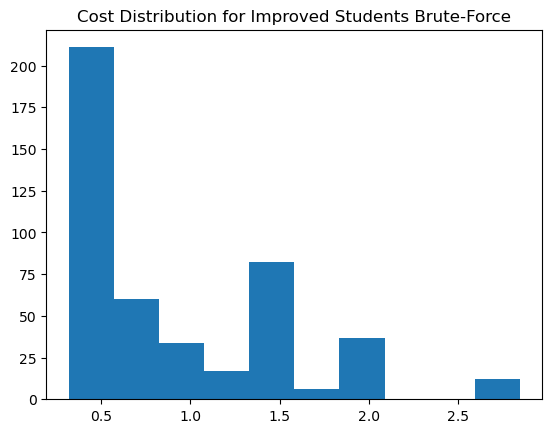

Changed Features
Self Lms                                 101
Internet Type                             58
Class Duration, Device                    38
Network Type                              35
Class Duration                            34
Internet Type, Class Duration, Device     26
Self Lms, Device                          23
Class Duration, Self Lms                  22
Internet Type, Self Lms                   20
Device                                    17
Name: count, dtype: int64


In [149]:
improved_df['Num Changes'] = improved_df['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)
plt.hist(improved_df['Cost'], bins=10)
plt.title('Cost Distribution for Improved Students Brute-Force')
plt.show()
print(improved_df['Changed Features'].value_counts().head(10))

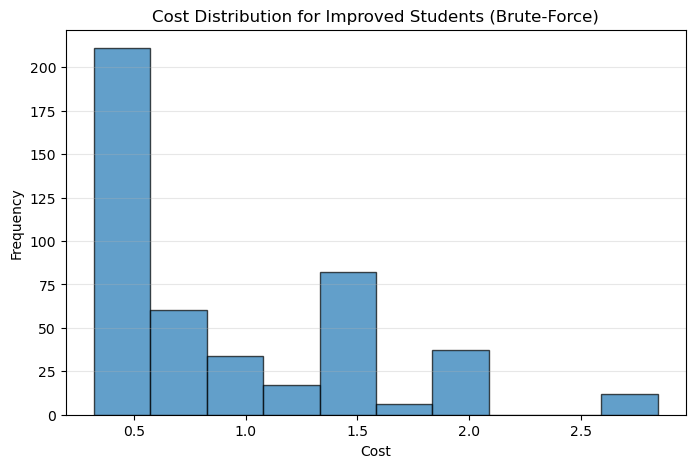

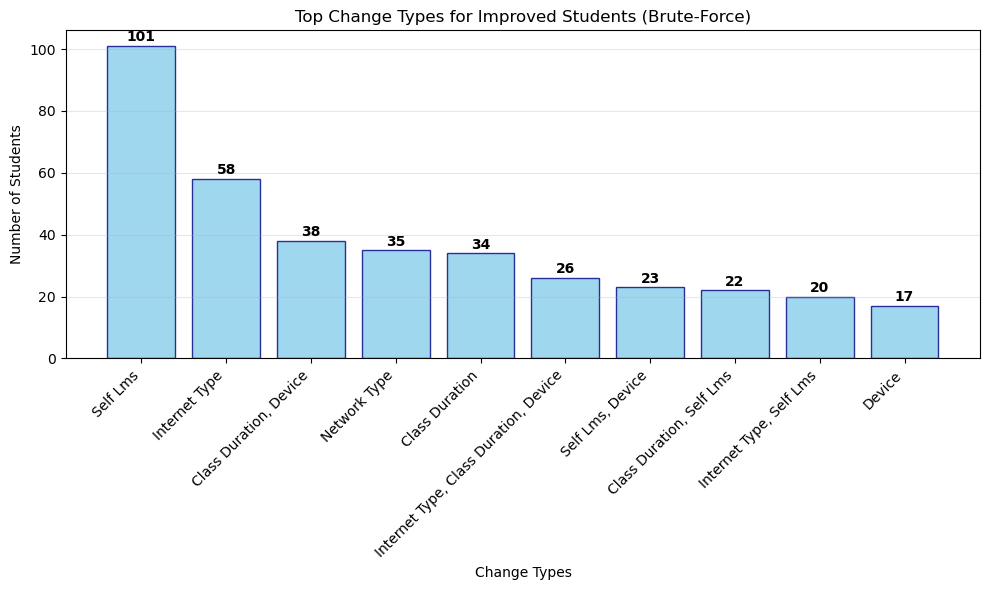

Top Change Types:
Changed Features
Self Lms                                 101
Internet Type                             58
Class Duration, Device                    38
Network Type                              35
Class Duration                            34
Internet Type, Class Duration, Device     26
Self Lms, Device                          23
Class Duration, Self Lms                  22
Internet Type, Self Lms                   20
Device                                    17
Name: count, dtype: int64


In [143]:
# Додаємо стовпець Num Changes
improved_df['Num Changes'] = improved_df['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)

# Гістограма для Cost
plt.figure(figsize=(8, 5))
plt.hist(improved_df['Cost'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Cost Distribution for Improved Students (Brute-Force)')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Value counts для Changed Features з бар-графіком та підписами на стовпцях
changes_counts = improved_df['Changed Features'].value_counts().head(10)  # Топ-10 для графіка

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(changes_counts)), changes_counts.values, color='skyblue', edgecolor='navy', alpha=0.8)
plt.title('Top Change Types for Improved Students (Brute-Force)')
plt.xlabel('Change Types')
plt.ylabel('Number of Students')
plt.xticks(range(len(changes_counts)), changes_counts.index, rotation=45, ha='right')  # Підписи з назвами змін на стовпцях
plt.grid(axis='y', alpha=0.3)

# Додаємо значення на стовпці
for bar, count in zip(bars, changes_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Друкуємо value counts для перевірки
print("Top Change Types:")
print(changes_counts.head(10))

# Objective ILP function

In [111]:
import pulp
from typing import Dict, List, Tuple, Optional

In [140]:
def run_ilp_optimization(alpha=0.05, threshold=0.3, low_df=None, modifiable_features=None, value_space=None, weights=None):
    """
    Function to run ILP optimization on Low-adaptability students using PuLP.
    Parameters:
    - alpha: Sparsity penalty.
    - threshold: SHAP-delta threshold for improvement surrogate.
    - low_df: DataFrame of Low students (default: from global df).
    - modifiable_features: List of modifiable features.
    - value_space: Dict of possible values for features.
    - weights: Dict of SHAP weights for features.
    Returns: results_df (full), improved_df (filtered).
    """
    if low_df is None:
        low_df = df[df['Adaptivity Level'] == 0].copy()
    if modifiable_features is None:
        modifiable_features = ['Internet Type', 'Network Type', 'Class Duration', 'Self Lms', 'Device']
    if value_space is None:
        value_space = {
            'Internet Type': [0, 1],
            'Network Type': [0, 1, 2],
            'Class Duration': [0, 1, 2],
            'Self Lms': [0, 1],
            'Device': [0, 1, 2]
        }
    if weights is None:
        weights = dict(zip(shap_df['Feature'], shap_df['Scaled SHAP Weight']))  # From global shap_df

    results = []

    for idx, row in low_df.iterrows():
        base = row.to_dict()
        
        # PuLP модель
        model = pulp.LpProblem(f"Opt_{idx}", pulp.LpMinimize)
        
        # Бінарні змінні x_(f,v): 1, якщо фіч f = v
        x_vars = {}
        for f in modifiable_features:
            for v in value_space[f]:
                x_vars[(f, v)] = pulp.LpVariable(f"x_{f}_{v}", cat='Binary')
            # Точно одне значення на фічу
            model += pulp.lpSum(x_vars[(f, v)] for v in value_space[f]) == 1
        
        # y_f: 1, якщо зміна (v != base[f])
        y_vars = {}
        for f in modifiable_features:
            base_v = base[f]
            y_vars[f] = pulp.LpVariable(f"y_{f}", cat='Binary')
            model += y_vars[f] >= pulp.lpSum(x_vars[(f, v)] for v in value_space[f] if v != base_v)
        
        # Цільова функція: alpha * sum y_f + sum w_f * y_f
        model += (alpha * pulp.lpSum(y_vars[f] for f in modifiable_features) + 
                  pulp.lpSum(weights[f] * y_vars[f] for f in modifiable_features))
        
        # Surrogate для покращення: delta SHAP >= threshold
        shap_delta = pulp.lpSum(weights[f] * (pulp.lpSum(v * x_vars[(f, v)] for v in value_space[f]) - base[f]) 
                                for f in modifiable_features)
        model += shap_delta >= threshold
        
        # Розв'язок
        model.solve(pulp.PULP_CBC_CMD(msg=0))
        
        if model.status == pulp.LpStatusOptimal:
            x_prime = {}
            for f in modifiable_features:
                for v in value_space[f]:
                    if pulp.value(x_vars[(f, v)]) == 1:
                        x_prime[f] = v
            changed = [f for f in modifiable_features if x_prime[f] != base[f]]
            cost = pulp.value(model.objective)
            
            # RF перевірка
            X_cols = [c for c in df.columns if c != 'Adaptivity Level']
            new_profile = base.copy()
            new_profile.update(x_prime)
            new_df = pd.DataFrame([{k: new_profile[k] for k in X_cols}])
            pred_new = rf_model.predict(new_df)[0]
            
            results.append({
                'Student ID': idx,
                'Changed Features': ', '.join(changed),
                'x_prime': x_prime,
                'Cost': round(cost, 3),
                'Old Class': 0,
                'New Class': pred_new,
                'Improved': int(pred_new > 0)
            })
        else:
            results.append({
                'Student ID': idx,
                'Changed Features': '-',
                'x_prime': {f: base[f] for f in modifiable_features},
                'Cost': 0,
                'Old Class': 0,
                'New Class': 0,
                'Improved': 0
            })
    
    results_df = pd.DataFrame(results)
    improved_df = results_df[results_df['Improved'] == 1]
    print(f"✅ Optimization complete for {len(results_df)} students. Improved: {len(improved_df)} ({len(improved_df)/len(results_df)*100:.1f}%).")
    
    if len(improved_df) > 0:
        print("Top 10 improved (sorted by Cost):")
        display(improved_df.head(10).sort_values('Cost'))
    else:
        print("❌ No improvements found — check RF sensitivity or value_space.")
        display(results_df.head(10))
    
    return results_df, improved_df

In [139]:
# --- Запуск функції (на всіх low_students) ---
results_df, improved_df_ilp = run_ilp_optimization(alpha=0.05, threshold=0.3)

✅ Optimization complete for 480 students. Improved: 87 (18.1%).
Top 10 improved (sorted by Cost):


,Student ID,Changed Features,x_prime,Cost,Old Class,New Class,Improved
4,10,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
5,11,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
10,18,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
29,68,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
39,93,Device,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.333,0,1,1
45,111,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
52,128,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
60,148,Device,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.333,0,1,1
18,44,Network Type,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.492,0,1,1
19,49,Network Type,"{'Internet Type': 1, 'Network Type': 2, 'Class...",0.492,0,1,1


In [141]:
improved_df[improved_df['New Class']==2]

,Student ID,Changed Features,x_prime,Cost,Old Class,New Class,Improved
258,617,Self Lms,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.32,0,2,1
322,778,Self Lms,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.32,0,2,1
342,839,Self Lms,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.32,0,2,1
361,894,Self Lms,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.32,0,2,1
368,914,Self Lms,"{'Internet Type': 0, 'Network Type': 1, 'Class...",0.32,0,2,1


C:\Users\oyuso\AppData\Local\Temp\ipykernel_10148\258831272.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)


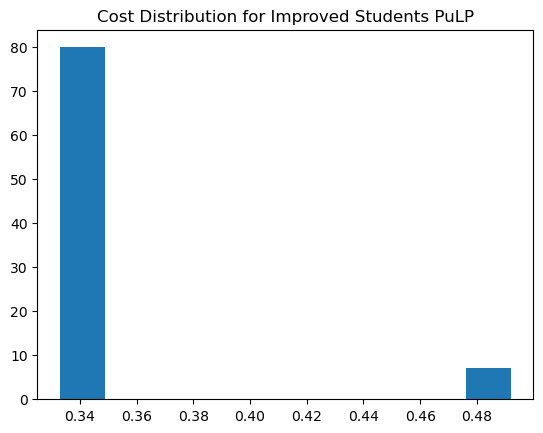

Changed Features
Device          80
Network Type     7
Name: count, dtype: int64


In [144]:
improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)
plt.hist(improved_df_ilp['Cost'], bins=10)
plt.title('Cost Distribution for Improved Students PuLP')
plt.show()
print(improved_df_ilp['Changed Features'].value_counts().head())

C:\Users\oyuso\AppData\Local\Temp\ipykernel_10148\3567996568.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)


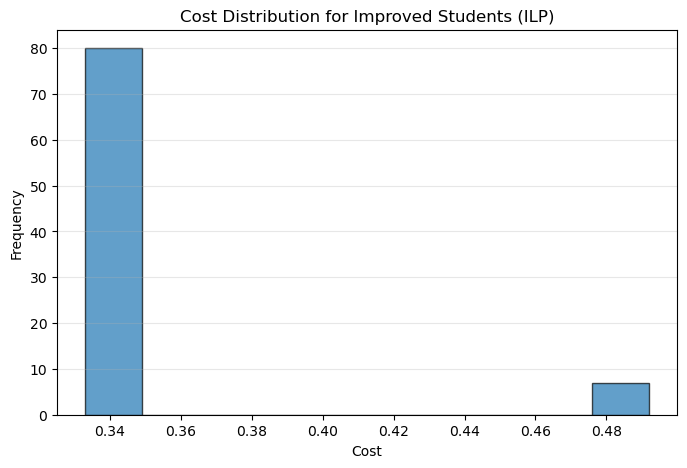

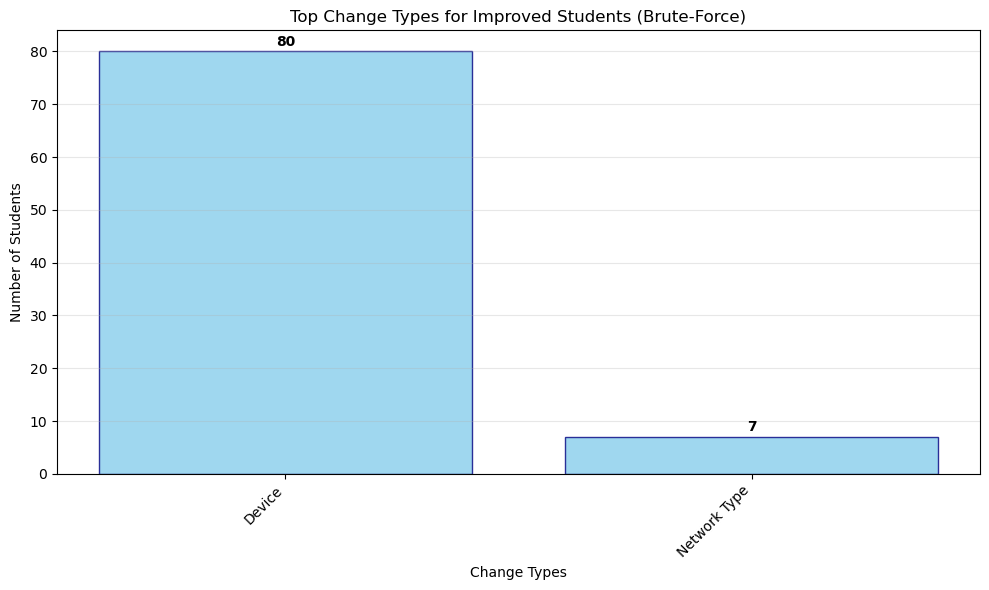

Top Change Types ILP:
Changed Features
Device          80
Network Type     7
Name: count, dtype: int64


In [145]:
# Додаємо стовпець Num Changes
improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)

# Гістограма для Cost
plt.figure(figsize=(8, 5))
plt.hist(improved_df_ilp['Cost'], bins=10, edgecolor='black', alpha=0.7)
plt.title('Cost Distribution for Improved Students (ILP)')
plt.xlabel('Cost')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.3)
plt.show()

# Value counts для Changed Features з бар-графіком та підписами на стовпцях
changes_counts = improved_df_ilp['Changed Features'].value_counts().head(10)  # Топ-10 для графіка

plt.figure(figsize=(10, 6))
bars = plt.bar(range(len(changes_counts)), changes_counts.values, color='skyblue', edgecolor='navy', alpha=0.8)
plt.title('Top Change Types for Improved Students (Brute-Force)')
plt.xlabel('Change Types')
plt.ylabel('Number of Students')
plt.xticks(range(len(changes_counts)), changes_counts.index, rotation=45, ha='right')  # Підписи з назвами змін на стовпцях
plt.grid(axis='y', alpha=0.3)

# Додаємо значення на стовпці
for bar, count in zip(bars, changes_counts.values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), 
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Друкуємо value counts для перевірки
print("Top Change Types ILP:")
print(changes_counts.head())

## Article visualization

C:\Users\oyuso\AppData\Local\Temp\ipykernel_10148\1631810076.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)


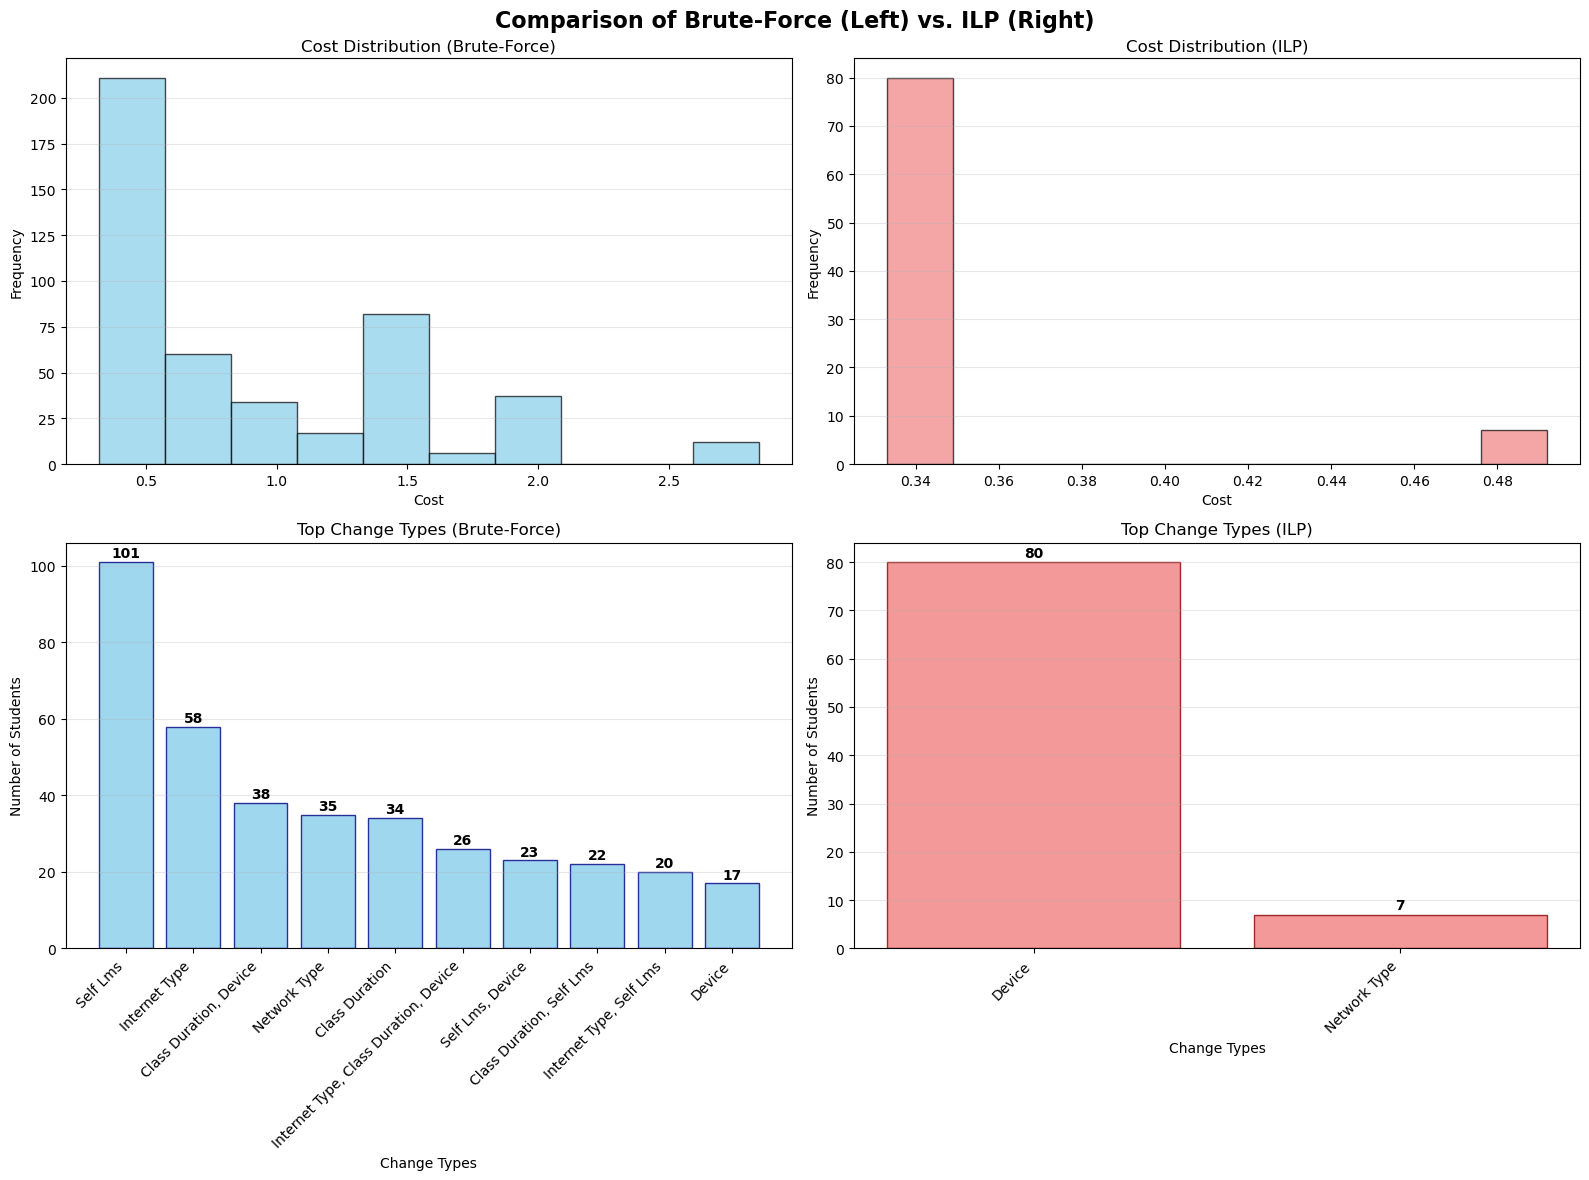

Top Change Types Brute-Force:
Changed Features
Self Lms                  101
Internet Type              58
Class Duration, Device     38
Network Type               35
Class Duration             34
Name: count, dtype: int64

Top Change Types ILP:
Changed Features
Device          80
Network Type     7
Name: count, dtype: int64


In [151]:
# Додаємо стовпець Num Changes для обох
improved_df['Num Changes'] = improved_df['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)
improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)

# Value counts для обох
changes_counts_bf = improved_df['Changed Features'].value_counts().head(10)
changes_counts_ilp = improved_df_ilp['Changed Features'].value_counts().head(10)

# Створюємо subplots: 2 rows x 2 columns (hist top, bars bottom)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparison of Brute-Force (Left) vs. ILP (Right)', fontsize=16, fontweight='bold')

# Row 1: Histograms of Cost
axes[0, 0].hist(improved_df['Cost'], bins=10, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].set_title('Cost Distribution (Brute-Force)')
axes[0, 0].set_xlabel('Cost')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

axes[0, 1].hist(improved_df_ilp['Cost'], bins=10, edgecolor='black', alpha=0.7, color='lightcoral')
axes[0, 1].set_title('Cost Distribution (ILP)')
axes[0, 1].set_xlabel('Cost')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

# Row 2: Bar charts of Change Types
x_bf = np.arange(len(changes_counts_bf))
bars_bf = axes[1, 0].bar(x_bf, changes_counts_bf.values, color='skyblue', edgecolor='navy', alpha=0.8)
axes[1, 0].set_title('Top Change Types (Brute-Force)')
axes[1, 0].set_xlabel('Change Types')
axes[1, 0].set_ylabel('Number of Students')
axes[1, 0].set_xticks(x_bf)
axes[1, 0].set_xticklabels(changes_counts_bf.index, rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Додаємо значення на стовпці для BF
for bar, count in zip(bars_bf, changes_counts_bf.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), 
                    ha='center', va='bottom', fontweight='bold')

x_ilp = np.arange(len(changes_counts_ilp))
bars_ilp = axes[1, 1].bar(x_ilp, changes_counts_ilp.values, color='lightcoral', edgecolor='darkred', alpha=0.8)
axes[1, 1].set_title('Top Change Types (ILP)')
axes[1, 1].set_xlabel('Change Types')
axes[1, 1].set_ylabel('Number of Students')
axes[1, 1].set_xticks(x_ilp)
axes[1, 1].set_xticklabels(changes_counts_ilp.index, rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

# Додаємо значення на стовпці для ILP
for bar, count in zip(bars_ilp, changes_counts_ilp.values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Друкуємо value counts для перевірки
print("Top Change Types Brute-Force:")
print(changes_counts_bf.head())
print("\nTop Change Types ILP:")
print(changes_counts_ilp.head())

C:\Users\oyuso\AppData\Local\Temp\ipykernel_10148\2871721856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)


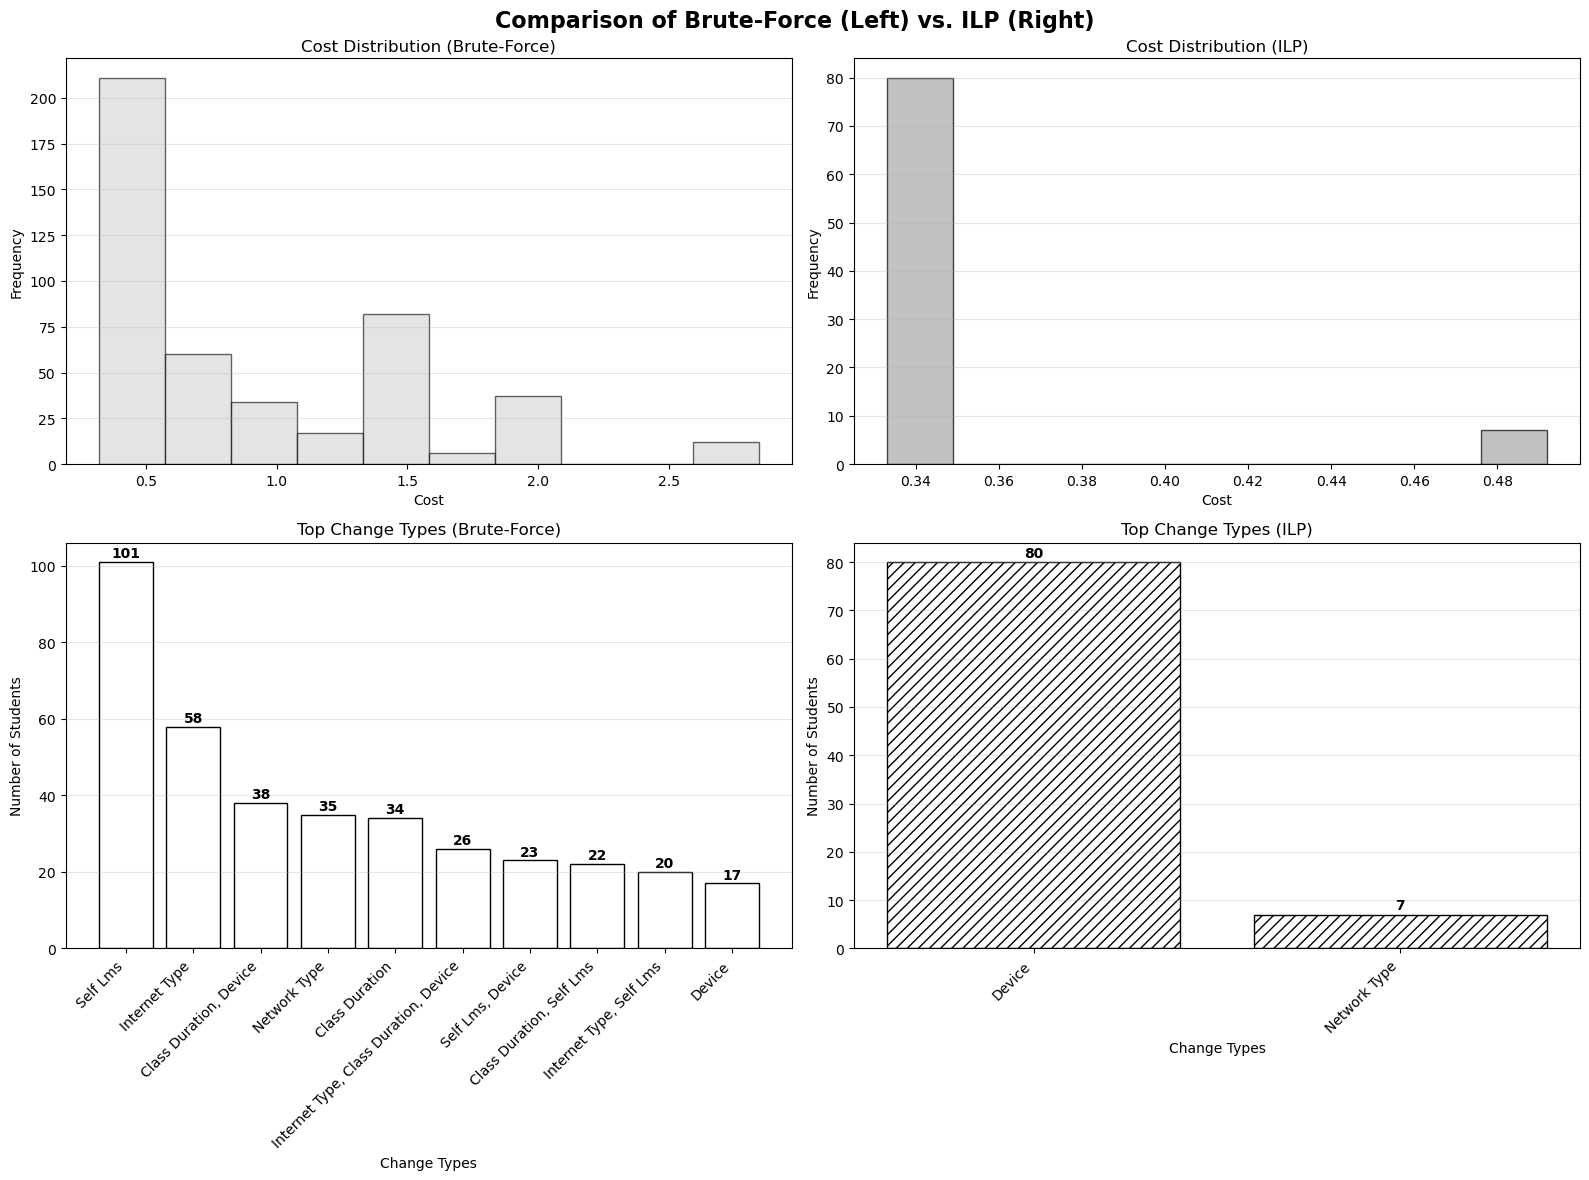

Top Change Types Brute-Force:
Changed Features
Self Lms                  101
Internet Type              58
Class Duration, Device     38
Network Type               35
Class Duration             34
Name: count, dtype: int64

Top Change Types ILP:
Changed Features
Device          80
Network Type     7
Name: count, dtype: int64


In [154]:
import matplotlib.pyplot as plt
import numpy as np

# Додаємо стовпець Num Changes для обох
improved_df['Num Changes'] = improved_df['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)
improved_df_ilp['Num Changes'] = improved_df_ilp['Changed Features'].apply(lambda x: len(x.split(', ')) if x != '-' else 0)

# Value counts для обох
changes_counts_bf = improved_df['Changed Features'].value_counts().head(10)
changes_counts_ilp = improved_df_ilp['Changed Features'].value_counts().head(10)

# Створюємо subplots: 2 rows x 2 columns (hist top, bars bottom)
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Comparison of Brute-Force (Left) vs. ILP (Right)', fontsize=16, fontweight='bold')

# Row 1: Histograms of Cost (grayscale)
axes[0, 0].hist(improved_df['Cost'], bins=10, edgecolor='black', alpha=0.6, color='lightgray')
axes[0, 0].set_title('Cost Distribution (Brute-Force)')
axes[0, 0].set_xlabel('Cost')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(axis='y', alpha=0.3)

axes[0, 1].hist(improved_df_ilp['Cost'], bins=10, edgecolor='black', alpha=0.7, color='darkgray')
axes[0, 1].set_title('Cost Distribution (ILP)')
axes[0, 1].set_xlabel('Cost')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(axis='y', alpha=0.3)

# Row 2: Bar charts of Change Types (patterns for B&W)
x_bf = np.arange(len(changes_counts_bf))
bars_bf = axes[1, 0].bar(x_bf, changes_counts_bf.values, color='white', edgecolor='black', hatch='', alpha=1, width=0.8)
axes[1, 0].set_title('Top Change Types (Brute-Force)')
axes[1, 0].set_xlabel('Change Types')
axes[1, 0].set_ylabel('Number of Students')
axes[1, 0].set_xticks(x_bf)
axes[1, 0].set_xticklabels(changes_counts_bf.index, rotation=45, ha='right')
axes[1, 0].grid(axis='y', alpha=0.3)

# Додаємо значення на стовпці для BF
for bar, count in zip(bars_bf, changes_counts_bf.values):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), 
                    ha='center', va='bottom', fontweight='bold')

x_ilp = np.arange(len(changes_counts_ilp))
bars_ilp = axes[1, 1].bar(x_ilp, changes_counts_ilp.values, color='white', edgecolor='black', hatch='///', alpha=1, width=0.8)
axes[1, 1].set_title('Top Change Types (ILP)')
axes[1, 1].set_xlabel('Change Types')
axes[1, 1].set_ylabel('Number of Students')
axes[1, 1].set_xticks(x_ilp)
axes[1, 1].set_xticklabels(changes_counts_ilp.index, rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

# Додаємо значення на стовпці для ILP
for bar, count in zip(bars_ilp, changes_counts_ilp.values):
    axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, str(count), 
                    ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

# Друкуємо value counts для перевірки
print("Top Change Types Brute-Force:")
print(changes_counts_bf.head())
print("\nTop Change Types ILP:")
print(changes_counts_ilp.head())

In [170]:
s1 = improved_df_ilp['Student ID'].copy()
s2 = results_df[results_df['New Class'] != 0]['Student ID'].copy()

print(np.sum(s1==s2))
print('К-ть студ у ilp', len(s2.index))
print('К-ть студ у bf', len(s1.index))
print(s1.difference(s2))
print(s2.index.difference(s1.index))


87
К-ть студ у ilp 87
К-ть студ у bf 87


AttributeError: 'Series' object has no attribute 'difference'

KeyError: True